## Stepper-Motor-Driver-using-RL78
---

This application note shows how to implement a controller for a stepper motor using the RL78 Hardware 16-Bit Single-Chip Microcontrollers (MCUs) along with a simple analog Drive circuit. Nowadays, stepper motors are used in a wide variety of applications. They are prevalent in consumer office equipment such as printers, scanners, copiers and plotters. They also play an important role in the industry, use in robotics or dashboard indicators, climate control systems in the automotive industry.

Purpose of this application note is to show how a stepper motor control is realised on the RL78/G13
with as few external parts as possible. The software and hardware configuration published here is
just a academic project (EL9630/NEA630 - Microprocessors) and are not intend for mass production.

### Stepper Motor Basics
---

A step motor is an electromagnetic, rotary actuator, which mechanically converts digital pulse inputs to
incremental shaft rotation. The rotation has not only a direct relation to the number of input pulses, but
its speed is related to the frequency of the pulses. 

#### Hybrid Stepper Motor
---

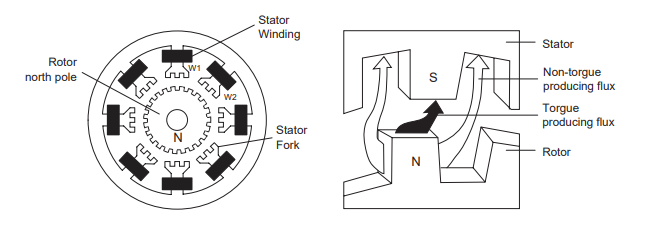

The drive topology of stepper motors is also an important criterion for choosing a motor.
Here are two main topologies to mention, unipolar and bipolar driving. Unipolar stepping motors are composed of two windings, each with a center tap. The center taps are either brought outside the motor as two separate wires or connected to each other internally and brought outside the motor as one wire. As a result, unipolar motors have 5 or 6 wires. Regardless of the
number of wires, unipolar motors are driven in the same way. The center tap wire(s) is tied to a power supply and the ends of the coils are alternately grounded.

#### 2 Phase Stepper Motor with one pole pair permanent magnet
---

Unipolar stepping motors operate by attracting the north or south poles of the permanently magnetized rotor to the stator poles. Thus, in these motors, the direction of the current through the stator windings determines which rotor poles will be attracted to which stator poles. Current direction in unipolar motors is dependent on which half of a winding is energized. Physically, the halves of the windings are wound
parallel to one another. Therefore, one winding acts as either a north or south pole depending on which
half is powered.

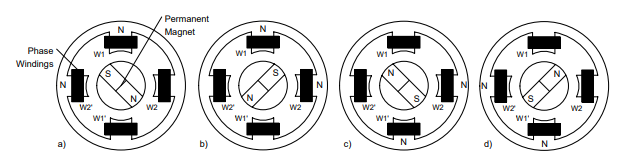

In the figure above you can see the four different energizing phases that are necessary to rotate the shaft one time. In the first phase W1 and W2’ are energized, in the second the current flows through W1 and W2 etc. In this application design a variant where two windings are energized at the same time has been chosen to produce more torque. The following figure shows the different energizing states for the
example motor above.

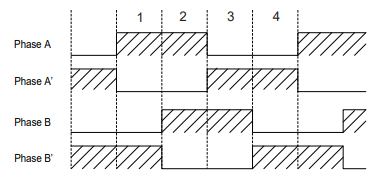

The full step modus is already shown in the example above, means that you need four steps in the simplest arrangements to obtain one shaft rotation. The angular resolution is 90 degrees. The difference of the half step operation lies in the fact that the phase coils are not always energized at the same time, but, as the associated figure shows also is switched off. Thus each step is halved, so that for a revolution 8 steps are necessary. The stepper angle halved itself thus on 45 degrees.

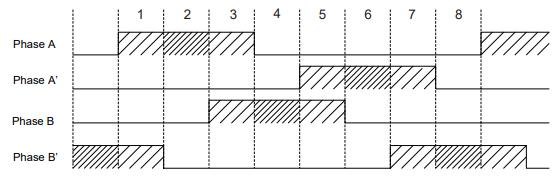

#### Stepper Motor Control Requirements | Unipolar Stepper Motor drive
---

As already mentioned this application design deals with an unipolar drive topology and focuses on the full and half-step operation mode. The principal driver design for an unipolar stepper motor is shown below.

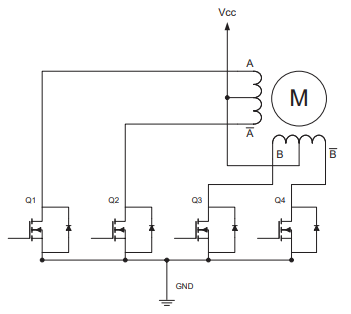

The following figure shows a schematic for general motor control design with a microcontroller.

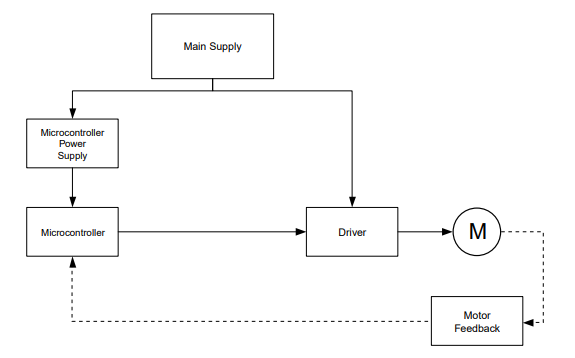

The functions of the components in detail:

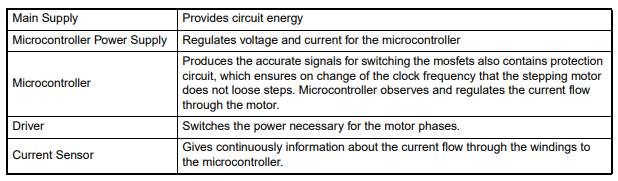

Stepper motor control requirements are summarized below:

• Driver circuit to provide necessary power for the stepper motor

• Current limiting device (software based)

• Interrupted based microcontroller algorithm to produce exact output signals

 #### System Concept
 ---
 
 The principal block diagram of the system concept for the stepper motor.
 
 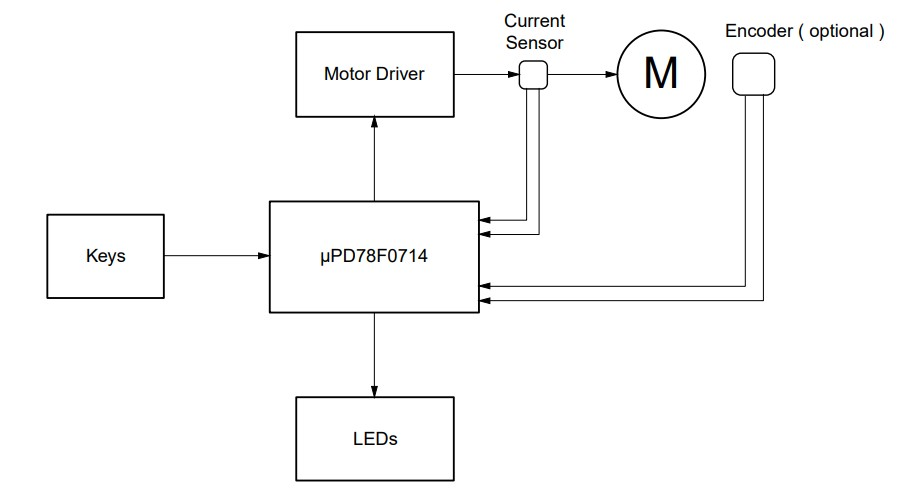

#### System Configuration
---

the system configurations and the peripherals of the MCU device used for the stepper motor control.

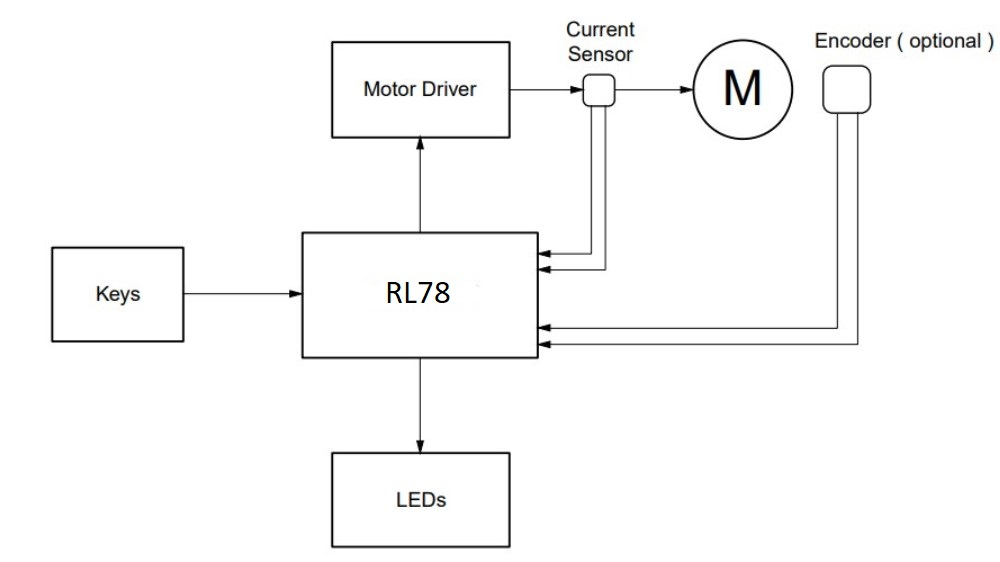

The Keys are control elements for enabling different running modes for the stepper motor.

#### System Topology and Relationship between the Control Software and Hardware of the System
---

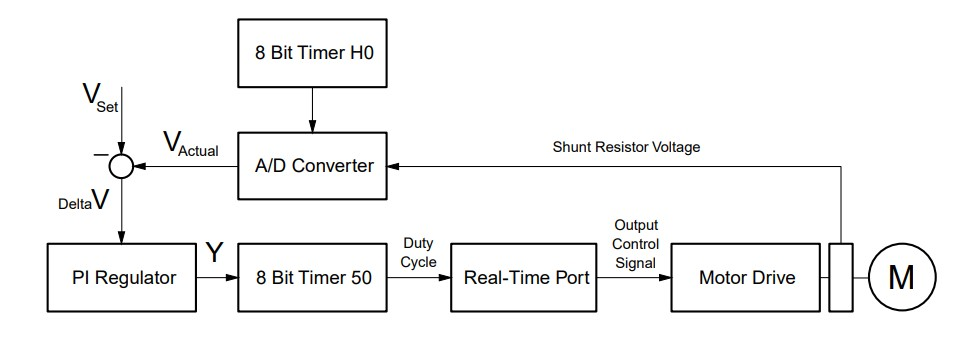

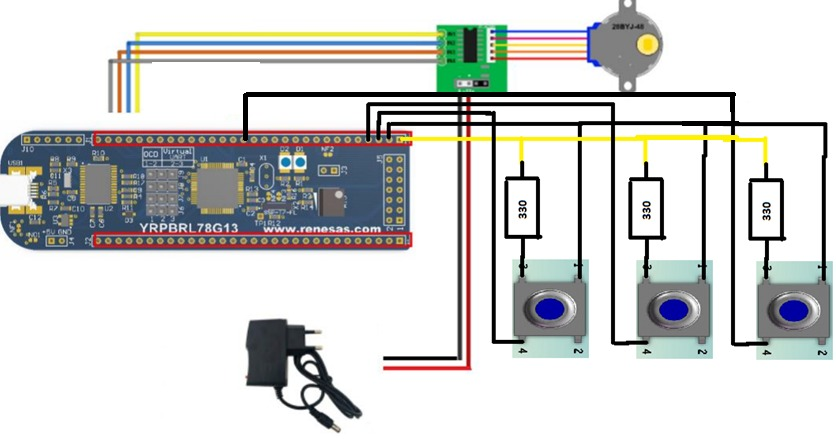

#### Inicialization Process
---

The initialization process is responsible for the initializing the µPD78F0714 device after a system reset. It configures the basic clock settings of the device, initializes the peripherals that are used for the motor control application and disables/ enables interrupts. The initialization contains two parts as shown in Figure, the first part that initializes the configuration of the device and the second part initialize the peripherals with their operating mode.

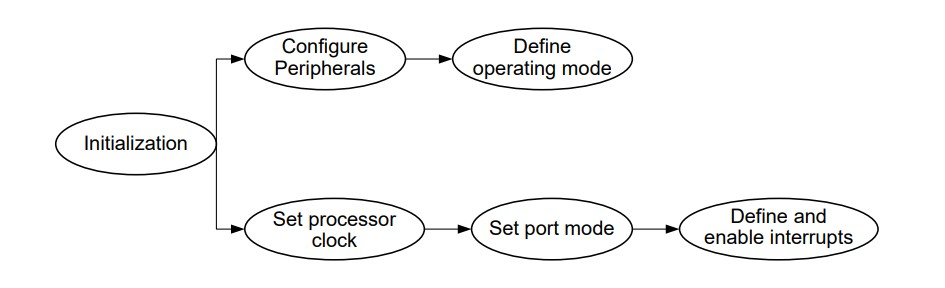

#### Main Program Flowchart
---


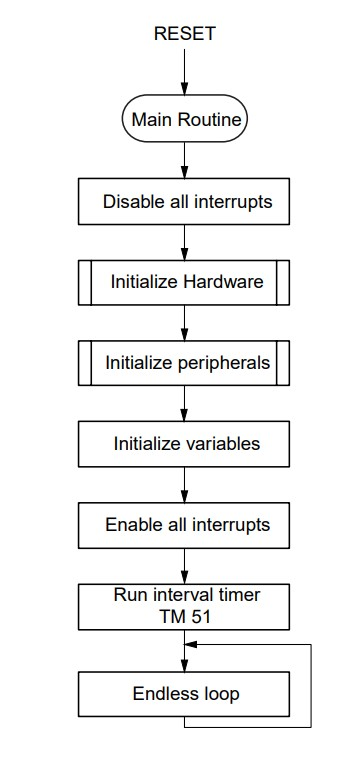

#### Main Routine
---

``` C

// MODULE = Main

void main(void)
{
  ADPC = 4; //Configura o pino do ADC
  ADCEN = 1; //Liga o ADC
  ADM0 = ADCLK_DIV64 | ADC_LV0 | bADCE; // Configura o ADC
  ADM1 = ADC_TRIG_SOFT;
  ADS = ADC_CH2;
  ADMK = 0;
  ADCS = 1;
  
  
  CMC = 0; // desativa osciladores X1 e XT1
  OSMC = bWUTMMCK0;  // configura o LOCO (15kHz) como fonte de clock do IT/RTC
  RTCEN = 1; 
  // Configura o IT para uma interrupção a cada 300 contagens, ou seja:
  // 3/15000 = 200us -> uma interrupção a cada 200us
  ITMC = bRINTE | 1;
  ITMK = 0; 
  
  
  EGN0 = BIT2 | BIT1;
  PIF1 = 0;
  //PIF2 = 0;
  PMK1 = 0;
  //PMK2 = 0;
  
  
  PM1_bit.no0 = 1; //Passo -> 1 = Meio passo / 0 = Passo Inteiro 
  PM1_bit.no1 = 1; //Direcao -> 1 = Antihorario / 0 = Horario 
  
  PM7_bit.no0 = 0; 
  PM7_bit.no1 = 0; 
  PM7_bit.no2 = 0; 
  PM7_bit.no3 = 0; 
  
  P7_bit.no0 = 1; //Enrolamento 1
  P7_bit.no1 = 1; //Enrolamento 2
  P7_bit.no2 = 1; //Enrolamento 3
  P7_bit.no2 = 1; //Enrolamento 4
  
 
  __enable_interrupt();
  while(1);
}

```

#### Disable all interrupts
---

#### Initialize Hardware
---

``` C

// MODULE = Hardware Initialization

// Watchdog config = Turn-off
#pragma location = "OPTBYTE"
__root __far const char opbyte0 = WDT_OFF; 
// Low-voltage detector config = desligado
#pragma location = "OPTBYTE"
__root __far const char opbyte1 = LVD_OFF; 
// Oscilator 32MHz flash high speed
#pragma location = "OPTBYTE"
__root __far const char opbyte2 = FLASH_HS | CLK_32MHZ;
// Debug activated, with erasure in case of authentication failure
#pragma location = "OPTBYTE"
__root __far const char opbyte3 = DEBUG_ON_ERASE; 
/* Security ID config */
#pragma location = "SECUID"
__root __far const char senha[10] = {0,0,0,0,0,0,0,0,0,0};

```

#### Initialize Peripherals
---

``` C

#pragma vector = INTIT_vect
__interrupt void trata_IT(void) //Interrupcao Timer, verifica o estado dos botões a cada 200us
{
  if(enable==1){
    switch (P) {
      case 0:
        switch (D)  {
        case 0:
            seta_enrolamentos(1,0,0,0); // Passo Inteiro, sentido Horário.
            seta_enrolamentos(0,1,0,0);
            seta_enrolamentos(0,0,1,0);
            seta_enrolamentos(0,0,0,1);  
            break;
          case 1:
            seta_enrolamentos(0,0,0,1);  // Passo Inteiro, sentido anti-Horário.
            seta_enrolamentos(0,0,1,0);
            seta_enrolamentos(0,1,0,0);
            seta_enrolamentos(1,0,0,0);
            break;
        }
        break;
        
        case 1:
        switch (D)  {
        case 0: // Meio Passo, sentido Horário.	
            seta_enrolamentos(1,0,0,0);
            seta_enrolamentos(1,1,0,0);
            seta_enrolamentos(0,1,0,0);
            seta_enrolamentos(0,1,1,0);
            seta_enrolamentos(0,0,1,0);
            seta_enrolamentos(0,0,1,1);
            seta_enrolamentos(0,0,0,1);
            seta_enrolamentos(1,0,0,1);
            break;
          case 1: // Meio Passo, sentido anti-Horário.	
            seta_enrolamentos(1,0,0,1); 
            seta_enrolamentos(0,0,0,1);
            seta_enrolamentos(0,0,1,1);
            seta_enrolamentos(0,0,1,0);
            seta_enrolamentos(0,1,1,0);
            seta_enrolamentos(0,1,0,0);
            seta_enrolamentos(1,1,0,0);
            seta_enrolamentos(1,0,0,0);
            break;
        }
        break;
    }
 }
}


#### Initialize Variables
---

```C

#pragma vector = INTP1_vect
__interrupt void trata_INTP1(){
  enable = !enable;
  seta_enrolamentos(0,0,0,0);
  conta_tempo(10000);
}

void seta_enrolamentos(int e1, int e2, int e3, int e4){
  P7_bit.no0 = e1; //Enrolamento 1
  P7_bit.no1 = e2; //Enrolamento 2
  P7_bit.no2 = e3; //Enrolamento 3
  P7_bit.no3 = e4; //Enrolamento 4
  conta_tempo(valor_time); 
}

```

#### Enable All Interrupts
---

``` C

  __enable_interrupt();
  while(1);

#pragma vector = INTAD_vect // Configuração para criação da função de interrupção de AD do microcontrolador
__interrupt void trata_ADC(){ //Interrup
  unsigned int result;
  result = ADCR >> 6; // Realização do shift de 6 bits a direita para ler a informação
  valor_time = result*1.5 + 1454;
  //A variavel "valor_time" controla o tempo do delay de acionamento dos enrolamentos
  //Temos uma frequencia de operação aproximada entre 1000 Hz e 486 Hz, quanto maior a frequencia, maior a velocidade do motor
  //A velocidade do motor ficou: 6 <-> 12.5 RPM em Meio passo | 12 <-> 25.3 RPM em Passo completo
  //Range de frequencias adotado baseado em testes do que o motor aceita
}

```

#### Run Internval timer
---

``` C

void conta_tempo(int teempo) //1454 = 100 Hz
{
  //volatile long int temp;
  volatile unsigned long int temp, cnt;
  for (temp=teempo;temp;temp--);
}

```

#### Endless Loop
---

``` C

#pragma vector = INTP1_vect
__interrupt void trata_INTP1(){
  enable = !enable;
  seta_enrolamentos(0,0,0,0);
  conta_tempo(10000);
}

```

#### YRPBRL78G13 Board Components & Schematics
---

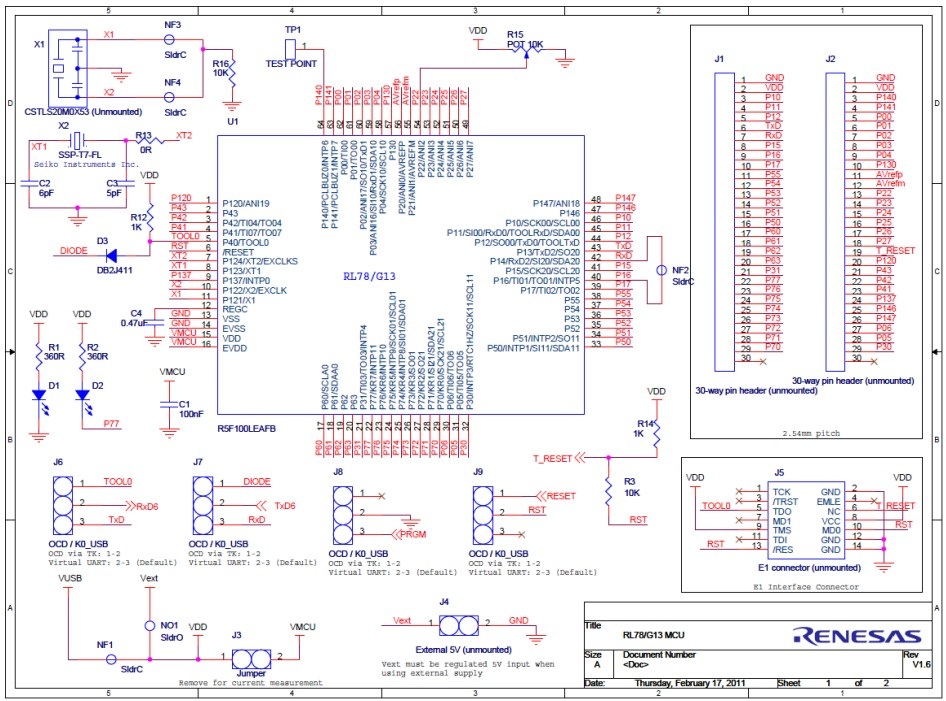
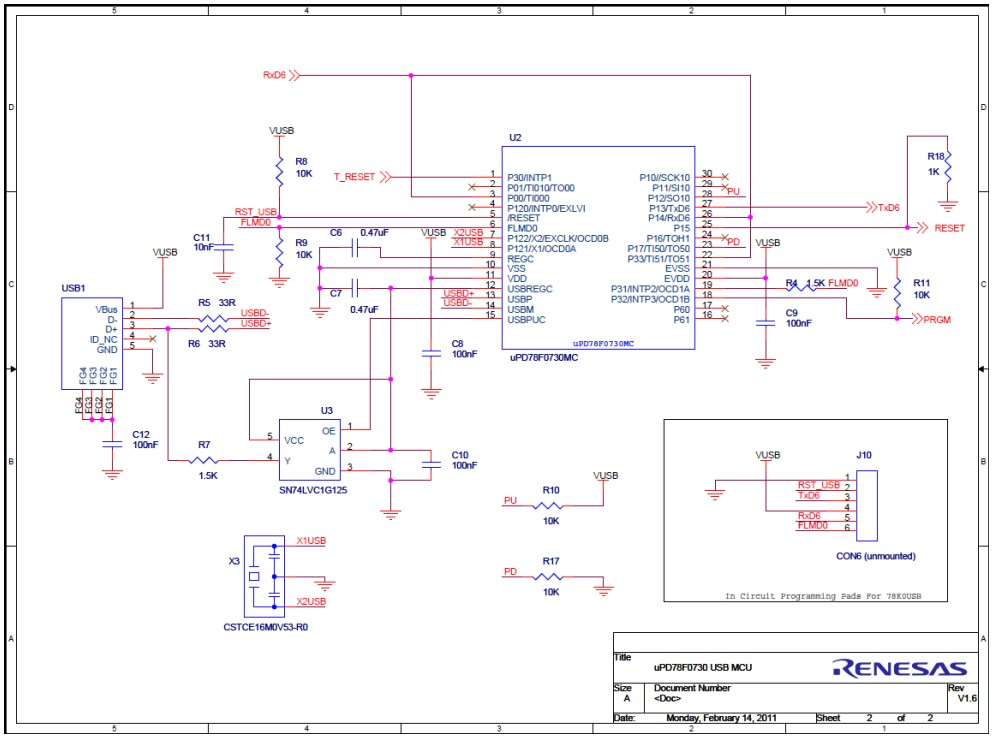